In [234]:
# feature encoder
#安裝函式庫編碼器
!pip install -q category_encoders

In [235]:
#安裝兩種函式庫，用於處理不平衡數據集
#-q安靜地安裝,-U如果已經安裝就更新到新版
!pip install -q -U imblearn
!pip install -q -U imbalanced-learn

In [236]:
#安裝三種函式庫
#xgboost 是一個基於樹模型的機器學習函式庫，提供高效率和高性能的機器學習模型。它支持並行和分佈式運算，可以處理大規模數據集。
#lightgbm 是一個基於樹模型的機器學習函式庫，提供高效率和高性能的機器學習模型。它支持並行和分佈式運算，可以處理大規模數據集。
#catboost 是一個基於樹模型的機器學習函式庫，支持分類和迴歸任務。它支持並行和分佈式運算，可以處理大規模數據集。
!pip install -U -q xgboost lightgbm catboost

In [237]:
#導入pandas並命名為pd
#從剛剛那些下載的安裝包裡面導入所需函數
import pandas as pd
from sklearn.model_selection import train_test_split

import gc
from sklearn.metrics import classification_report, accuracy_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

from sklearn.utils import resample
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import numpy as np
from scipy import stats
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

import category_encoders as ce

from collections import Counter
from imblearn.over_sampling import SMOTE


import pickle
import seaborn as sns

import itertools

import warnings
warnings.filterwarnings("ignore")

In [238]:
#連線到我的雲端硬碟
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [239]:
#讀取我雲端硬碟中的這個檔案
#把這個資料命名成df
data= '/content/gdrive/MyDrive/2023/2023-2-Python-AI/data/archive.zip'
df=pd.read_csv(data)

In [240]:
#顯示頭兩筆資料
df.head(2)

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0


In [241]:
#info,檔案資訊
#10種欄位是數字,2種欄位是文字
#目標是找出客戶流失率
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


In [242]:
#isnull,是空的嗎?如果為真sum,總和給我
df.isnull().sum()

customer_id         0
credit_score        0
country             0
gender              0
age                 0
tenure              0
balance             0
products_number     0
credit_card         0
active_member       0
estimated_salary    0
churn               0
dtype: int64

# **下面都在檢查流失率,從多個角度**

In [243]:
# rate of churn; too low to take care
# only 20 % in churm
#在churn這個欄位,用mean平均數來找出流失率,2037/10000

df[['churn']].mean()

churn    0.2037
dtype: float64

In [244]:
# churn indepement of one's gender
#groupby群組gender性別aggregate彙總churn流失率
df.groupby("gender").agg({"churn": ["mean","count"]})

churn      
            mean count
gender                
Female  0.250715  4543
Male    0.164559  5457

In [245]:
# churn rate of Germany is igher than others
#groupby群組country國家aggregate彙總churn流失率
df.groupby("country").agg({"churn": ["mean","count"]})

churn      
             mean count
country                
France   0.161548  5014
Germany  0.324432  2509
Spain    0.166734  2477

In [246]:
#  churn rate indepent of whether owns creredict card
#流失率與信用卡有關嗎
df.groupby("credit_card").agg({"churn": ["mean","count"]})

churn      
                 mean count
credit_card                
0            0.208149  2945
1            0.201843  7055

In [247]:
# churn rate is lower if one registered from activity
#註冊會員有更低的流失率
df.groupby("active_member").agg({"churn": ["mean","count"]})


churn      
                   mean count
active_member                
0              0.268509  4849
1              0.142691  5151

In [248]:
# the more one purchased, the more one is in churn state
#買越多產品客戶流失率越高
df.groupby("products_number").agg({"churn": ["mean","count"]})

churn      
                     mean count
products_number                
1                0.277144  5084
2                0.075817  4590
3                0.827068   266
4                1.000000    60

In [249]:
# no info?

df.groupby("tenure").agg({"churn": ["mean","count"]})

churn      
            mean count
tenure                
0       0.230024   413
1       0.224155  1035
2       0.191794  1048
3       0.211100  1009
4       0.205258   989
5       0.206522  1012
6       0.202689   967
7       0.172179  1028
8       0.192195  1025
9       0.216463   984
10      0.206122   490

# **找出特徵種類**

In [250]:
#將我們要找到的target目標變數設定為churn流失率
#categorical_variables列表生成式
#不同值要小於10確保該欄位不是目標變數churn
#滿足這任一條件就加入列表

target= 'churn'
categorical_variables = [col for col in df if col in "O"
                         or df[col].nunique() <=10
                         and col not in target]
print("Categorical Features: ",categorical_variables)

Categorical Features:  ['country', 'gender', 'products_number', 'credit_card', 'active_member']


In [251]:
#numeric_variables列表式生成
#是否有object非數值欄位
#是否大於5
#滿足任一條件加入列表

numeric_variables = [col for col in df.columns if df[col].dtype != "object"
                        and df[col].nunique() >5]
print("Numerical Features: ",numeric_variables)

Numerical Features:  ['customer_id', 'credit_score', 'age', 'tenure', 'balance', 'estimated_salary']


In [252]:
#計算不同個數的種類
#國家三種,性別兩種,產品數量4種,會員非會員兩種,有無信用卡兩種,流失或未流失兩種
df.nunique()

customer_id         10000
credit_score          460
country                 3
gender                  2
age                    70
tenure                 11
balance              6382
products_number         4
credit_card             2
active_member           2
estimated_salary     9999
churn                   2
dtype: int64

# **數據標準化的過程**

Conclusion
---
The features, <b>`tenue`</b> and <b>`estimated_salary`</B>, are not distributed absolutely in Gaussian obviously!

Data normalized
---
Nonamized data do help to modeling; different type
 different conversion:
 1. sklearn.preprocessing.StandardScaler: Data in normal.
 $$\bar X_i=\frac{X_i-EX}{\sigma (X)}\sim N(0,1)$$
 2. sklearn.preprocessing.MinMaxScaler: Data in abnomal
 $$ \bar X_i=\frac{X_i-X_\min}{X_\max-X_\min}\sim U(0,1)$$

In [253]:
#把上面的公式導入
def StandardScaler(df,cols):
    for col in cols:
        df[col] = (df[col] - df[col].mean()) / df[col].std()
    return df
def NormalizationScaler(df,cols):
    for col in cols:
        df[col] = (df[col] - df[col].min()) / (df[col] .max()- df[col].min())
    return df

However numeric_variables[0]= `customer_id` redudent, each one owning unique one, give up.

In [254]:
# data saved
#存檔
saved='/content/gdrive/MyDrive/2023/2023-2-Python-AI/data/churn-data20240525.csv'
df.to_csv(saved,index=False)

Data Washing, (Feature Engineer)
---
There are some packages that automatical do `Feature Engineering` work, suchas
- [Featuretools](https://github.com/alteryx/featuretools),
- [sklearn](https://scikit-learn.org/stable/)
```python
from sklearn.feature_selection import f_regression
scores, _ = f_regression(df.iloc[:,0:2], df.iloc[:,-1])
print(scores)
```
- [Feature-engine](https://feature-engine.trainindata.com/en/latest/)

Here, we manually do these works:

a). delete redundant features,`customer_id`<br>
b).

In [389]:
#導入這個資料並開始做,初始化從這裡開始
df = pd.read_csv('/content/gdrive/MyDrive/2023/2023-2-Python-AI/data/churn-data20240525.csv')

In [390]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   credit_score             10000 non-null  int64  
 1   country                  10000 non-null  object 
 2   gender                   10000 non-null  object 
 3   age                      10000 non-null  float64
 4   tenure                   10000 non-null  float64
 5   balance                  10000 non-null  float64
 6   products_number          10000 non-null  int64  
 7   credit_card              10000 non-null  int64  
 8   active_member            10000 non-null  int64  
 9   estimated_salary         10000 non-null  float64
 10  CreditsScore             10000 non-null  int64  
 11  Age                      10000 non-null  int64  
 12  Balance                  10000 non-null  int64  
 13  EstSalary                10000 non-null  float64
 14  Tenure                 

In [391]:
# drop un-required features

#刪掉一個欄位,
def clean_data20240525(df):
    # Drop rows with missing data across all columns
    df.dropna(inplace=True)
    # Drop columns:  'customer_id',
    df.drop(columns=['customer_id'], inplace=True)
    return df

df_clean = clean_data20240525(df)

In [392]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      10000 non-null  int64  
 1   country           10000 non-null  object 
 2   gender            10000 non-null  object 
 3   age               10000 non-null  int64  
 4   tenure            10000 non-null  int64  
 5   balance           10000 non-null  float64
 6   products_number   10000 non-null  int64  
 7   credit_card       10000 non-null  int64  
 8   active_member     10000 non-null  int64  
 9   estimated_salary  10000 non-null  float64
 10  churn             10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


In [393]:
df_clean.head(2)

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0


In [394]:
# sklean example
# H0: the regression coefficient is equal to zero.
# i.e. non-implantant freture to be used to predictctarget

from sklearn.feature_selection import f_regression
scores, p_vals = f_regression(df.iloc[:,4:9], df.iloc[:,-1])
# Print the feature names and scores
for i, score in enumerate(scores):
    print(f"Feature {i+4}: {df.columns[i+4]} - Score: {score:.3f}, with p-value: {p_vals[i]:.2f}")

Feature 4: tenure - Score: 1.960, with p-value: 0.16
Feature 5: balance - Score: 142.474, with p-value: 0.00
Feature 6: products_number - Score: 22.915, with p-value: 0.00
Feature 7: credit_card - Score: 0.509, with p-value: 0.48
Feature 8: active_member - Score: 249.801, with p-value: 0.00


In [395]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      10000 non-null  int64  
 1   country           10000 non-null  object 
 2   gender            10000 non-null  object 
 3   age               10000 non-null  int64  
 4   tenure            10000 non-null  int64  
 5   balance           10000 non-null  float64
 6   products_number   10000 non-null  int64  
 7   credit_card       10000 non-null  int64  
 8   active_member     10000 non-null  int64  
 9   estimated_salary  10000 non-null  float64
 10  churn             10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


In [396]:
# Feature Engineering
# binning the data
#把重複性低的資料分箱,計算並新增一些欄位
#新增Tenure=tenure/age
#新增Tenure_add_age=tenure+age
#新增Tenure_minus_age=tenure-age
#新增Tenure_times_age=tenure*age
df_clean["CreditsScore"] = pd.qcut(df_clean['credit_score'], 6, labels = [1, 2, 3, 4, 5, 6])
df_clean["Age"] = pd.qcut(df_clean['age'], 8, labels = [1, 2, 3, 4, 5, 6, 7, 8])
df_clean["Balance"] = pd.qcut(df_clean['balance'].rank(method="first"), 5, labels = [1, 2, 3, 4, 5])
df_clean["EstSalary"] = pd.qcut(df_clean['estimated_salary'], 10, labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
df_clean["Tenure"] = df_clean["tenure"]/df_clean["age"]
df_clean["Tenure_add_age"] = df_clean["tenure"]+df_clean["age"]
df_clean["Tenure_minus_age"] = df_clean["tenure"]-df_clean["age"]
df_clean["Tenure_times_age"] = df_clean["tenure"]*df_clean["age"]
df_clean.dtypes

credit_score           int64
country               object
gender                object
age                    int64
tenure                 int64
balance              float64
products_number        int64
credit_card            int64
active_member          int64
estimated_salary     float64
churn                  int64
CreditsScore        category
Age                 category
Balance             category
EstSalary           category
Tenure               float64
Tenure_add_age         int64
Tenure_minus_age       int64
Tenure_times_age       int64
dtype: object

In [397]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   credit_score      10000 non-null  int64   
 1   country           10000 non-null  object  
 2   gender            10000 non-null  object  
 3   age               10000 non-null  int64   
 4   tenure            10000 non-null  int64   
 5   balance           10000 non-null  float64 
 6   products_number   10000 non-null  int64   
 7   credit_card       10000 non-null  int64   
 8   active_member     10000 non-null  int64   
 9   estimated_salary  10000 non-null  float64 
 10  churn             10000 non-null  int64   
 11  CreditsScore      10000 non-null  category
 12  Age               10000 non-null  category
 13  Balance           10000 non-null  category
 14  EstSalary         10000 non-null  category
 15  Tenure            10000 non-null  float64 
 16  Tenure_add_age    10000

In [398]:
df_clean.tail()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,CreditsScore,Age,Balance,EstSalary,Tenure,Tenure_add_age,Tenure_minus_age,Tenure_times_age
9995,771,France,Male,39,5,0.00,2,1,0,96270.64,0,6,5,2,5,0.128205,44,-34,195
9996,516,France,Male,35,10,57369.61,1,1,1,101699.77,0,1,3,2,6,0.285714,45,-25,350
9997,709,France,Female,36,7,0.00,1,0,1,42085.58,1,5,4,2,3,0.194444,43,-29,252
9998,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1,6,6,3,5,0.071429,45,-39,126
9999,792,France,Female,28,4,130142.79,1,1,0,38190.78,0,6,1,4,2,0.142857,32,-24,112


In [399]:
#  data

y_clean = df_clean[target]
df_clean = df_clean.drop(target,axis=1)

In [400]:
#檢查資料性質
df_clean.dtypes

credit_score           int64
country               object
gender                object
age                    int64
tenure                 int64
balance              float64
products_number        int64
credit_card            int64
active_member          int64
estimated_salary     float64
CreditsScore        category
Age                 category
Balance             category
EstSalary           category
Tenure               float64
Tenure_add_age         int64
Tenure_minus_age       int64
Tenure_times_age       int64
dtype: object

In [401]:
#檢查資料重複度
df_clean.nunique()

credit_score         460
country                3
gender                 2
age                   70
tenure                11
balance             6382
products_number        4
credit_card            2
active_member          2
estimated_salary    9999
CreditsScore           6
Age                    8
Balance                5
EstSalary             10
Tenure               414
Tenure_add_age        75
Tenure_minus_age      75
Tenure_times_age     363
dtype: int64

In [402]:
# Binary Feature value;
# convert the last four categorical features to numeric ones
#把CreditsScore,Age,Balance轉化成整數型
#把EstSalary轉化成浮點數型
features_=['CreditsScore','Age','Balance']
for f_ in features_:
    df_clean[f_] = df_clean[f_].astype(int)

df_clean['EstSalary'] = df_clean['EstSalary'].astype(float)

In [403]:
df_clean.dtypes

credit_score          int64
country              object
gender               object
age                   int64
tenure                int64
balance             float64
products_number       int64
credit_card           int64
active_member         int64
estimated_salary    float64
CreditsScore          int64
Age                   int64
Balance               int64
EstSalary           float64
Tenure              float64
Tenure_add_age        int64
Tenure_minus_age      int64
Tenure_times_age      int64
dtype: object

In [404]:
# prompt: delete pandas column

#df_clean.drop(columns=['age','tenure','balance','estimated_salary'],axis=1,inplace=True)

# **用剛剛定義過的公式把數據標準化**

Nornamize data
---

In [405]:
df_clean.head(2)

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,CreditsScore,Age,Balance,EstSalary,Tenure,Tenure_add_age,Tenure_minus_age,Tenure_times_age
0,619,France,Female,42,2,0.00,1,1,1,101348.88,3,6,1,6.0,0.047619,44,-40,84
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,2,6,3,6.0,0.024390,42,-40,41


In [406]:
df_clean=StandardScaler(df_clean,['age','balance','estimated_salary'])

In [407]:
df_clean= NormalizationScaler(df_clean,['tenure'])

In [408]:
df_clean.head(2)

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,CreditsScore,Age,Balance,EstSalary,Tenure,Tenure_add_age,Tenure_minus_age,Tenure_times_age
0,619,France,Female,0.293503,0.2,-1.225786,1,1,1,0.021885,3,6,1,6.0,0.047619,44,-40,84
1,608,Spain,Female,0.198154,0.1,0.117344,1,0,1,0.216523,2,6,3,6.0,0.024390,42,-40,41


In [409]:
df_clean.dtypes

credit_score          int64
country              object
gender               object
age                 float64
tenure              float64
balance             float64
products_number       int64
credit_card           int64
active_member         int64
estimated_salary    float64
CreditsScore          int64
Age                   int64
Balance               int64
EstSalary           float64
Tenure              float64
Tenure_add_age        int64
Tenure_minus_age      int64
Tenure_times_age      int64
dtype: object

In [410]:
# combine features,string feafures only
# 組合特徵，僅字串特徵
def feature_bind(df,col1,col2):
    df[col1+'_'+col2]=df[col1].astype(str)+df[col2].astype(str)
    return df

In [411]:
df_clean =  feature_bind(df_clean,'country','gender')
df_clean =  feature_bind(df_clean,'country','products_number')
df_clean =  feature_bind(df_clean,'country','Age')
df_clean =  feature_bind(df_clean,'gender','Age')
df_clean =  feature_bind(df_clean,'gender','products_number')
df_clean =  feature_bind(df_clean,'Age','products_number')


In [412]:
df_clean.dtypes

credit_score                 int64
country                     object
gender                      object
age                        float64
tenure                     float64
balance                    float64
products_number              int64
credit_card                  int64
active_member                int64
estimated_salary           float64
CreditsScore                 int64
Age                          int64
Balance                      int64
EstSalary                  float64
Tenure                     float64
Tenure_add_age               int64
Tenure_minus_age             int64
Tenure_times_age             int64
country_gender              object
country_products_number     object
country_Age                 object
gender_Age                  object
gender_products_number      object
Age_products_number         object
dtype: object

In [413]:
# database diveded

y = y_clean
X = df_clean


In [414]:
X.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,...,Tenure,Tenure_add_age,Tenure_minus_age,Tenure_times_age,country_gender,country_products_number,country_Age,gender_Age,gender_products_number,Age_products_number
0,619,France,Female,0.293503,0.2,-1.225786,1,1,1,0.021885,...,0.047619,44,-40,84,FranceFemale,France1,France6,Female6,Female1,61
1,608,Spain,Female,0.198154,0.1,0.117344,1,0,1,0.216523,...,0.024390,42,-40,41,SpainFemale,Spain1,Spain6,Female6,Female1,61
2,502,France,Female,0.293503,0.8,1.332987,3,1,0,0.240675,...,0.190476,50,-34,336,FranceFemale,France3,France6,Female6,Female3,63
3,699,France,Female,0.007456,0.1,-1.225786,2,0,0,-0.108912,...,0.025641,40,-38,39,FranceFemale,France2,France5,Female5,Female2,52
4,850,Spain,Female,0.388852,0.2,0.785689,1,1,1,-0.365258,...,0.046512,45,-41,86,SpainFemale,Spain1,Spain6,Female6,Female1,61


In [415]:
y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 10000 entries, 0 to 9999
Series name: churn
Non-Null Count  Dtype
--------------  -----
10000 non-null  int64
dtypes: int64(1)
memory usage: 78.2 KB


Feature Engineering
---
1. create new features:<br>
   a. 'gender'+'products_number'<br>
   b. 'customer': 'country'+'gender'<br>
   c. 'active_member'+'country'<br>
   d. 'country'+'products_number'<br>

In [416]:

#X.drop(columns=['country_llo_enc','customers_llo_enc',	'customer1_llo_enc'],axis=1,inplace=True)

In [417]:
X.head(2)

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,...,Tenure,Tenure_add_age,Tenure_minus_age,Tenure_times_age,country_gender,country_products_number,country_Age,gender_Age,gender_products_number,Age_products_number
0,619,France,Female,0.293503,0.2,-1.225786,1,1,1,0.021885,...,0.047619,44,-40,84,FranceFemale,France1,France6,Female6,Female1,61
1,608,Spain,Female,0.198154,0.1,0.117344,1,0,1,0.216523,...,0.024390,42,-40,41,SpainFemale,Spain1,Spain6,Female6,Female1,61


In [418]:
def llo_encoder(df,col,target=y):
    df[col+'_llo_enc']=df[col]
    loo_encoder = ce.LeaveOneOutEncoder(cols=[col+'_llo_enc'], sigma=0.05)
    loo_encoder.fit(df, target)
    X_encoded = loo_encoder.transform(df)
    return X_encoded

In [419]:

f_convert=['country_gender','country_products_number','country_Age','gender_Age','gender_products_number','Age_products_number']
for col in f_convert:
    X_enc=llo_encoder(X,col)
    X=X_enc

In [420]:
X.head(2)

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,...,country_Age,gender_Age,gender_products_number,Age_products_number,country_gender_llo_enc,country_products_number_llo_enc,country_Age_llo_enc,gender_Age_llo_enc,gender_products_number_llo_enc,Age_products_number_llo_enc
0,619,France,Female,0.293503,0.2,-1.225786,1,1,1,0.021885,...,France6,Female6,Female1,61,0.203450,0.224344,0.206838,0.288288,0.331882,0.323151
1,608,Spain,Female,0.198154,0.1,0.117344,1,0,1,0.216523,...,Spain6,Female6,Female1,61,0.212121,0.218673,0.212903,0.288288,0.331882,0.323151


In [421]:
def target_encoder(df,col,target=y):
    df[col+'_target_enc']=df[col]
    target_encoder = ce.TargetEncoder(cols=[col+'_target_enc'])
    target_encoder.fit(df, target)
    X_encoded = target_encoder.transform(df)
    return X_encoded

In [422]:

f_convert=['country_gender','country_products_number','country_Age','gender_Age','gender_products_number','Age_products_number']
for col in f_convert:
    X_enc=target_encoder(X,col)
    X=X_enc

In [423]:
X.head(2)

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,...,country_Age_llo_enc,gender_Age_llo_enc,gender_products_number_llo_enc,Age_products_number_llo_enc,country_gender_target_enc,country_products_number_target_enc,country_Age_target_enc,gender_Age_target_enc,gender_products_number_target_enc,Age_products_number_target_enc
0,619,France,Female,0.293503,0.2,-1.225786,1,1,1,0.021885,...,0.206838,0.288288,0.331882,0.323151,0.203450,0.224344,0.206838,0.288288,0.331882,0.323151
1,608,Spain,Female,0.198154,0.1,0.117344,1,0,1,0.216523,...,0.212903,0.288288,0.331882,0.323151,0.212121,0.218673,0.212903,0.288288,0.331882,0.323151


In [424]:
def glmm_encoder(df,col,target=y):
    df[col+'_glmm_enc']=df[col]
    glmm_encoder = ce.GLMMEncoder(cols=col, binomial_target=True)
    glmm_encoder.fit(df, target)
    X_encoded = glmm_encoder.transform(df)
    return X_encoded

In [425]:
f_convert=['country_gender','country_products_number','country_Age','gender_Age','gender_products_number','Age_products_number']
for col in f_convert:
    X_enc=glmm_encoder(X,col)
    X=X_enc

In [426]:
X.head(2)

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,...,country_Age_target_enc,gender_Age_target_enc,gender_products_number_target_enc,Age_products_number_target_enc,country_gender_glmm_enc,country_products_number_glmm_enc,country_Age_glmm_enc,gender_Age_glmm_enc,gender_products_number_glmm_enc,Age_products_number_glmm_enc
0,619,France,Female,0.293503,0.2,-1.225786,1,1,1,0.021885,...,0.206838,0.288288,0.331882,0.323151,FranceFemale,France1,France6,Female6,Female1,61
1,608,Spain,Female,0.198154,0.1,0.117344,1,0,1,0.216523,...,0.212903,0.288288,0.331882,0.323151,SpainFemale,Spain1,Spain6,Female6,Female1,61


In [427]:
# binary

X['gender']=X['gender'].apply(lambda x:1 if x=='Female' else 0)


In [428]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 42 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   credit_score                        10000 non-null  int64  
 1   country                             10000 non-null  object 
 2   gender                              10000 non-null  int64  
 3   age                                 10000 non-null  float64
 4   tenure                              10000 non-null  float64
 5   balance                             10000 non-null  float64
 6   products_number                     10000 non-null  int64  
 7   credit_card                         10000 non-null  int64  
 8   active_member                       10000 non-null  int64  
 9   estimated_salary                    10000 non-null  float64
 10  CreditsScore                        10000 non-null  int64  
 11  Age                                 10000 

In [429]:
X.head(5)

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,...,country_Age_target_enc,gender_Age_target_enc,gender_products_number_target_enc,Age_products_number_target_enc,country_gender_glmm_enc,country_products_number_glmm_enc,country_Age_glmm_enc,gender_Age_glmm_enc,gender_products_number_glmm_enc,Age_products_number_glmm_enc
0,619,France,1,0.293503,0.2,-1.225786,1,1,1,0.021885,...,0.206838,0.288288,0.331882,0.323151,FranceFemale,France1,France6,Female6,Female1,61
1,608,Spain,1,0.198154,0.1,0.117344,1,0,1,0.216523,...,0.212903,0.288288,0.331882,0.323151,SpainFemale,Spain1,Spain6,Female6,Female1,61
2,502,France,1,0.293503,0.8,1.332987,3,1,0,0.240675,...,0.206838,0.288288,0.865770,0.823063,FranceFemale,France3,France6,Female6,Female3,63
3,699,France,1,0.007456,0.1,-1.225786,2,0,0,-0.108912,...,0.137427,0.208809,0.101942,0.067524,FranceFemale,France2,France5,Female5,Female2,52
4,850,Spain,1,0.388852,0.2,0.785689,1,1,1,-0.365258,...,0.212903,0.288288,0.331882,0.323151,SpainFemale,Spain1,Spain6,Female6,Female1,61


In [430]:
X.drop(columns=['country','country_gender_glmm_enc','country_products_number_glmm_enc','country_Age_glmm_enc','gender_Age_glmm_enc','gender_products_number_glmm_enc','Age_products_number_glmm_enc','gender_Age_target_enc','country_Age_target_enc','country_gender_target_enc'],axis=1,inplace=True)


In [431]:
X.head(2)

,credit_score,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,CreditsScore,...,Age_products_number,country_gender_llo_enc,country_products_number_llo_enc,country_Age_llo_enc,gender_Age_llo_enc,gender_products_number_llo_enc,Age_products_number_llo_enc,country_products_number_target_enc,gender_products_number_target_enc,Age_products_number_target_enc
0,619,1,0.293503,0.2,-1.225786,1,1,1,0.021885,3,...,-0.867827,0.203450,0.224344,0.206838,0.288288,0.331882,0.323151,0.224344,0.331882,0.323151
1,608,1,0.198154,0.1,0.117344,1,0,1,0.216523,2,...,-0.867827,0.212121,0.218673,0.212903,0.288288,0.331882,0.323151,0.218673,0.331882,0.323151


Data Imbalance
---
SMOTE + ENN

`A.` SMOTE selected each sample from the minority samples successively as the root sample for the synthesis of the new sample. <BR>
`B.` The following result was obtained by employing ENN to eliminate noise samples when the process of SMOTE is caused.

In [432]:
# imbalance set
#從imblearn導入SMOTEENN,用以處理不平衡資料庫
#定義了一個名為 imbalance_set 的函數，該函數接受兩個參數：X 和 y。X 是特徵矩陣，y 是標籤向量。
#這行代碼創建了一個 SMOTEENN 物件，並設置了隨機種子（random_state=42）以確保結果的可重現性。
#使用 fit_resample 方法對資料進行擬合並重抽樣。X_resampled 和 y_resampled 是重抽樣後的特徵矩陣和標籤向量。
#計算重抽樣後每個類別的樣本數量，並將其打印出來。這有助於檢查重抽樣是否達到了預期效果。
#返回重抽樣後的特徵矩陣和標籤向量。
from imblearn.combine import SMOTEENN


def imbance_set(X,y):
    # Create the SMOTEENN object
    sme = SMOTEENN(random_state=42)

    # Fit and resample the data
    X_resampled, y_resampled = sme.fit_resample(X, y)

    # Counting churn values
    churn_counts = y_resampled.value_counts()
    print(churn_counts)
    return X_resampled, y_resampled

In [433]:
#X.drop(columns=['country_gender_glmm_enc','country_products_number_glmm_enc',	'country_Age_glmm_enc'],axis=1,inplace=True)

In [434]:
X,y=imbance_set(X,y)

churn
1    6061
0    4229
Name: count, dtype: int64


In [435]:
len(X)

10290

In [436]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10290 entries, 0 to 10289
Data columns (total 32 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   credit_score                        10290 non-null  int64  
 1   gender                              10290 non-null  int64  
 2   age                                 10290 non-null  float64
 3   tenure                              10290 non-null  float64
 4   balance                             10290 non-null  float64
 5   products_number                     10290 non-null  int64  
 6   credit_card                         10290 non-null  int64  
 7   active_member                       10290 non-null  int64  
 8   estimated_salary                    10290 non-null  float64
 9   CreditsScore                        10290 non-null  int64  
 10  Age                                 10290 non-null  int64  
 11  Balance                             10290

In [437]:
X.columns

Index(['credit_score', 'gender', 'age', 'tenure', 'balance', 'products_number',
       'credit_card', 'active_member', 'estimated_salary', 'CreditsScore',
       'Age', 'Balance', 'EstSalary', 'Tenure', 'Tenure_add_age',
       'Tenure_minus_age', 'Tenure_times_age', 'country_gender',
       'country_products_number', 'country_Age', 'gender_Age',
       'gender_products_number', 'Age_products_number',
       'country_gender_llo_enc', 'country_products_number_llo_enc',
       'country_Age_llo_enc', 'gender_Age_llo_enc',
       'gender_products_number_llo_enc', 'Age_products_number_llo_enc',
       'country_products_number_target_enc',
       'gender_products_number_target_enc', 'Age_products_number_target_enc'],
      dtype='object')

In [438]:
features=list(X.columns)
target = 'churn'

In [439]:
X[features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10290 entries, 0 to 10289
Data columns (total 32 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   credit_score                        10290 non-null  int64  
 1   gender                              10290 non-null  int64  
 2   age                                 10290 non-null  float64
 3   tenure                              10290 non-null  float64
 4   balance                             10290 non-null  float64
 5   products_number                     10290 non-null  int64  
 6   credit_card                         10290 non-null  int64  
 7   active_member                       10290 non-null  int64  
 8   estimated_salary                    10290 non-null  float64
 9   CreditsScore                        10290 non-null  int64  
 10  Age                                 10290 non-null  int64  
 11  Balance                             10290

測試中

In [440]:
#刪除這些['credit_score','gender','tenure','tenure','balance','credit_card','estimated_salary','CreditsScore','Age','Balance','EstSalary','Tenure','Tenure_add_age','Tenure_minus_age','Tenure_times_age','country_gender_target_enc','country_Age_target_enc']

#X.drop(columns=['credit_score','gender','tenure','tenure','balance','credit_card','estimated_salary','CreditsScore','age','Balance','EstSalary','Tenure','Tenure_add_age','Tenure_minus_age','Tenure_times_age','country_gender_target_enc','country_Age_target_enc'],axis=1,inplace=True)


In [441]:
#X.drop(columns=['gender_Age_target_enc','country_Age_target_enc','country_gender_target_enc'],axis=1,inplace=True)

In [442]:
#X["add1"] = X["country_Age_llo_enc"]+X["active_member"]
#X["add2"] = X["country_products_number_target_enc"]+X["country_gender_llo_enc"]
#X["add3"] = X["country_products_number_llo_enc"]+X["products_number"]

In [443]:
#X=X.iloc[:,0:-1]

In [444]:
#X["1"] = X["country_Age_llo_enc"]*X["country_products_number_target_enc"]
#X["2"] = X["country_Age_llo_enc"]+X["country_products_number_target_enc"]
#X["3"] = X["country_Age_llo_enc"]*X["country_products_number_target_enc"]

In [445]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10290 entries, 0 to 10289
Data columns (total 32 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   credit_score                        10290 non-null  int64  
 1   gender                              10290 non-null  int64  
 2   age                                 10290 non-null  float64
 3   tenure                              10290 non-null  float64
 4   balance                             10290 non-null  float64
 5   products_number                     10290 non-null  int64  
 6   credit_card                         10290 non-null  int64  
 7   active_member                       10290 non-null  int64  
 8   estimated_salary                    10290 non-null  float64
 9   CreditsScore                        10290 non-null  int64  
 10  Age                                 10290 non-null  int64  
 11  Balance                             10290

Model
---
database -> train set and test set

In [446]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.04, random_state = 42)

In [447]:
from xgboost import XGBClassifier
XGB_model = XGBClassifier()
XGB_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [448]:
y_pred = XGB_model.predict(X_test)

In [449]:
# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print('test Accuracy:', accuracy)

# Calculate the recall
recall = recall_score(y_test, y_pred)
print('test Recall:', recall)

# Calculate the F1 score
f1 = f1_score(y_test, y_pred)
print('test F1 score:', f1)

test Accuracy: 0.9733009708737864
test Recall: 0.9620253164556962
test F1 score: 0.9764453961456103


In [450]:
y_pred

array([0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0,
       1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1,

In [451]:
feat_importances_df = feat_importances.reset_index()
feat_importances_df.columns = ['Feature', 'Importance']
print(feat_importances_df)


                               Feature  Importance
0                     estimated_salary    0.003022
1                            EstSalary    0.003470
2                         CreditsScore    0.003487
3                     Tenure_times_age    0.003577
4                               tenure    0.003655
5                   gender_Age_llo_enc    0.003681
6                               Tenure    0.003822
7      country_products_number_llo_enc    0.003836
8                         credit_score    0.003944
9                       Tenure_add_age    0.004018
10                                 age    0.005797
11                         country_Age    0.005977
12                             balance    0.006151
13                         credit_card    0.006371
14                    Tenure_minus_age    0.006574
15                          gender_Age    0.007124
16                             Balance    0.007247
17                 country_Age_llo_enc    0.007704
18                             

In [452]:
# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print('test Accuracy:', accuracy)

# Calculate the recall
recall = recall_score(y_test, y_pred)
print('test Recall:', recall)

# Calculate the F1 score
f1 = f1_score(y_test, y_pred)
print('test F1 score:', f1)

test Accuracy: 0.9733009708737864
test Recall: 0.9620253164556962
test F1 score: 0.9764453961456103


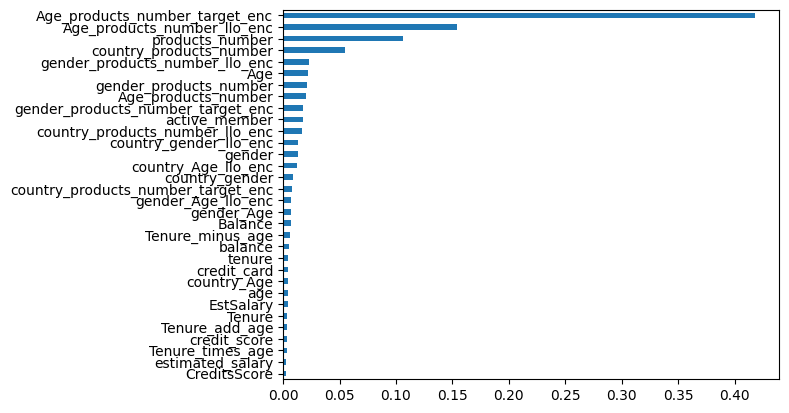

In [453]:
feat_importances = pd.Series(XGB_model.feature_importances_, index = X_train.columns).sort_values(ascending = True)
feat_importances.plot(kind = 'barh');

In [454]:
feat_importances_df = feat_importances.reset_index()
feat_importances_df.columns = ['Feature', 'Importance']
print(feat_importances_df)


                               Feature  Importance
0                         CreditsScore    0.002631
1                     estimated_salary    0.002648
2                     Tenure_times_age    0.003252
3                         credit_score    0.003284
4                       Tenure_add_age    0.003687
5                               Tenure    0.003788
6                            EstSalary    0.003978
7                                  age    0.004094
8                          country_Age    0.004239
9                          credit_card    0.004403
10                              tenure    0.004557
11                             balance    0.005054
12                    Tenure_minus_age    0.006300
13                             Balance    0.006663
14                          gender_Age    0.006985
15                  gender_Age_llo_enc    0.007107
16  country_products_number_target_enc    0.008131
17                      country_gender    0.009083
18                 country_Age_

In [455]:
# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print('test Accuracy:', accuracy)

# Calculate the recall
recall = recall_score(y_test, y_pred)
print('test Recall:', recall)

# Calculate the F1 score
f1 = f1_score(y_test, y_pred)
print('test F1 score:', f1)

test Accuracy: 0.9733009708737864
test Recall: 0.9620253164556962
test F1 score: 0.9764453961456103


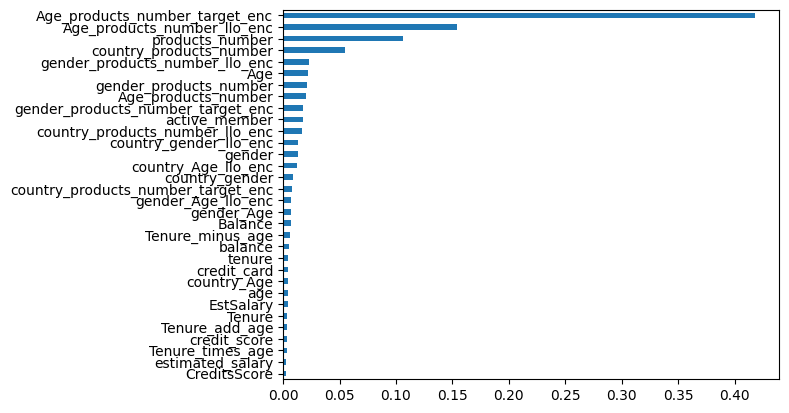

In [456]:
feat_importances = pd.Series(XGB_model.feature_importances_, index = X_train.columns).sort_values(ascending = True)
feat_importances.plot(kind = 'barh');